# Fitting PSF shapes and positions at the same time.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

Here I load in some data I have stored for the continuous viewing zone of TESS. This is all the sources in the continuous viewing zone on one camera. 

- $f$ is the log of the normalized flux
- $fe$ is the error on the log of the normalized flux
- $x$ is the position relative to the source center in column direction
- $y$ is the position relative to the source center in row direction
- $c$ is the column position
- $r$ is the row position

In [2]:
data = pickle.load(open('catalogs/tpf_01.p', 'rb'))
f, fe, x, y, c, r = data['y'], data['ye'], data['dx'], data['dy'], data['r'], data['c']

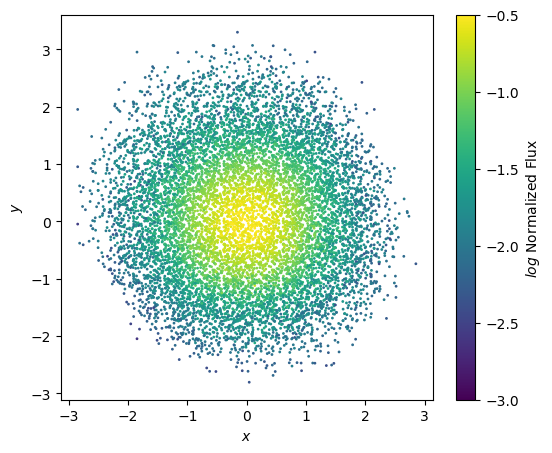

In [3]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.scatter(x, y, c=f, s=1, vmin=-3, vmax=-0.5)
cbar = plt.colorbar(im, ax=ax)
ax.set(xlabel='$x$', ylabel='$y$')
cbar.set_label("$log$ Normalized Flux")

We want to fit a Gaussian to the center of each source. This is our functional form for a Gaussian

$$
G(x, y) = -2\pi\sigma_x\sigma_y\sqrt{1-\rho^2} e^{-\frac{1}{2(1-\rho^2)}\left(\frac{(x-\mu_x)^2}{\sigma_x^2} + \frac{(y-\mu_y)^2}{\sigma_y^2} - \frac{2\rho(x-\mu_x)(y-\mu_y)}{\sigma_x\sigma_y}\right)}
$$

This is 2D, and has cross terms to enable rotation

In log space we have this:

$$ 
\ln(G(x, y)) = -\ln(2\pi\sigma_x\sigma_y\sqrt{1-\rho^2}) - \frac{x^2}{2(1-\rho^2)\sigma_x^2} - \frac{y^2}{2(1-\rho^2)\sigma_y^2} + 2\frac{\rho xy}{2(1-\rho^2)\sigma_x\sigma_y}
$$

This is a linear model where


$$ 
\ln(G(x, y)) = a + bx^2 + cy^2 + 2dxy
$$

$$ a = -\ln(2\pi\sigma_x\sigma_y\sqrt{1-\rho^2}) $$
$$ b = \frac{1}{2(1-\rho^2)\sigma_x^2}$$
$$ c = \frac{1}{2(1-\rho^2)\sigma_y^2}$$
$$ d = \frac{\rho}{2(1-\rho^2)\sigma_x\sigma_y}$$

We can rearrange this to get $\sigma_x$, $\sigma_y$

$$
\sigma_x = \sqrt{-\frac{1}{2b(1-\rho^2)}}
$$
$$
\sigma_y = \sqrt{-\frac{1}{2c(1-\rho^2)}}
$$


And then we can substitute those in to find $\rho$


$$ d = \frac{\rho}{2(1-\rho^2)\sqrt{-\frac{1}{2b(1-\rho^2)}}\sqrt{-\frac{1}{2c(1-\rho^2)}}}$$

$$
 d = \frac{\rho}{2(1-\rho^2)\sqrt{\frac{1}{4bc(1-\rho^2)^2}}}
 $$

$$
 d = \frac{\rho}{\sqrt{\frac{1}{bc}}}
$$

$$
 \rho = \sqrt{\frac{d^2}{bc}}
$$

Put another way, if we can fit this linear model and find the $a$, $b$, $c$, and $d$ that best fit the data, we will be able to find the best fitting standard deviation and correlation.

We will need to fit a design matrix that looks like

\begin{bmatrix}
1 & x_1^2 & y_1^2 & x_1y_1 \\
1 & x_2^2 & y_2^2 & x_2y_2 \\
1 & x_3^2 & y_3^2 & x_3y_3 \\
\vdots & \vdots & \vdots & \vdots \\
1 & x_n^2 & y_n^2 & x_ny_n
\end{bmatrix}

and then fit it to our data to find weights.

In [4]:
X = np.vstack([x**0, x**2, y**2, x * y]).T

We can make the assumption that close to the center of the source, the function is close to a Gaussian. This is because the effect of measurement in the pixel effectively convolves the function with a boxcar, and the PSF is likely to be peaky, resulting in something that we can approximate as a Gaussian. 

We'll only fit the model to the central pixels

In [5]:
k = np.hypot(y, x) < 1
sigma_w_inv = X[k].T.dot(X[k]/fe[k, None]**2)
B = X[k].T.dot(f[k]/fe[k]**2)
w = np.linalg.solve(sigma_w_inv, B)
werr = np.linalg.inv(sigma_w_inv).diagonal()**0.5

In [6]:
w

array([-0.52237448, -0.50552041, -0.51219115,  0.00199117])

We can plot that linear model and check it looks good. 

[Text(0, 0.5, '$log$ Normalized Flux'), Text(0.5, 0, '$\\sqrt{x^2 + y^2}$')]

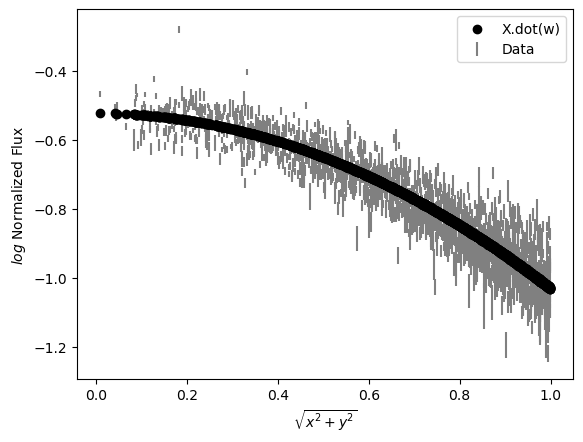

In [7]:
fig, ax = plt.subplots()
ax.errorbar(np.hypot(x, y)[k], f[k], fe[k], color='grey', ls='', label='Data')
ax.scatter(np.hypot(x, y)[k], X.dot(w)[k], c='k', label='X.dot(w)', zorder=10)
plt.legend()
ax.set(ylabel="$log$ Normalized Flux", xlabel='$\sqrt{x^2 + y^2}$')

Looks great. We've found the weights, let's convert them back into the properties of the Gaussian.

In [8]:
A = w[0]
rho = w[3]**2/(w[1]*w[2])
sigma_x = np.sqrt(-(1/(2*w[1] * (1-rho**2))))
sigma_y = np.sqrt(-(1/(2*w[2] * (1-rho**2))))

A_err = werr[0]
w3_err = np.abs((w[3]**2) * 2 * werr[3]/w[3])
rho_err = np.abs(rho) * np.sqrt((w3_err/w[3])**2 + (werr[1]/w[1])**2 + (werr[2]/w[2])**2)
sigma_x_2_err = np.sqrt(((np.abs((rho) * 2 * rho_err/rho))**2 + (werr[1]/w[1])**2))
sigma_x_err = np.abs(sigma_x * -0.5 * (sigma_x_2_err/sigma_x**2))

sigma_y_2_err = np.sqrt(((np.abs((rho) * 2 * rho_err/rho))**2 + (werr[2]/w[2])**2))
sigma_y_err = np.abs(sigma_y * -0.5 * (sigma_y_2_err/sigma_y**2))

We can confirm that those properties, when put into the equation for the log Gaussian provide the same result.

$$ 
\ln(G(x, y)) = -\ln(2\pi\sigma_x\sigma_y\sqrt{1-\rho^2}) - \frac{x^2}{2(1-\rho^2)\sigma_x^2} - \frac{y^2}{2(1-\rho^2)\sigma_y^2} + 2\frac{\rho xy}{2(1-\rho^2)\sigma_x\sigma_y}
$$


In [9]:
logG_x_y = A - (x**2)/(2 * (1-rho**2)*sigma_x**2) - (y**2)/(2 * (1-rho**2)*sigma_y**2) + ((2 * rho * x * y)/(2 * (1-rho**2) * sigma_x * sigma_y))

[Text(0, 0.5, '$log$ Normalized Flux'), Text(0.5, 0, '$\\sqrt{x^2 + y^2}$')]

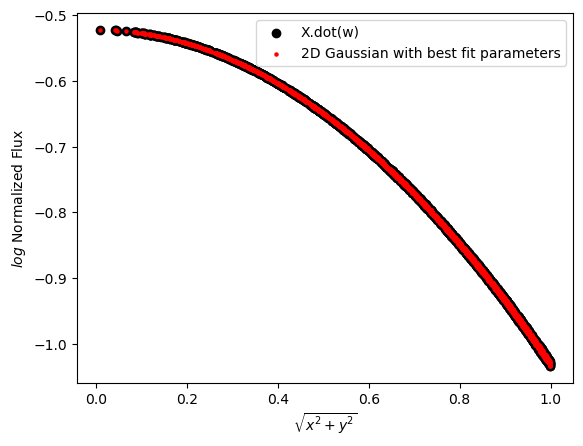

In [10]:
fig, ax = plt.subplots()
ax.scatter(np.hypot(x, y)[k], X.dot(w)[k], c='k', label='X.dot(w)')
ax.scatter(np.hypot(x, y)[k], logG_x_y[k], s=5, c='r', label='2D Gaussian with best fit parameters')
plt.legend()
ax.set(ylabel="$log$ Normalized Flux", xlabel='$\sqrt{x^2 + y^2}$')

Looks great. Now we're able to use our linear model to calculate the standard deviation and rotation of the Gaussian. 

Now that we have a good fit for the shape at the center, we can look for any slight shifts in the centers of the sources. 

We can take the partial derivative of our expression for the log Gaussian to get the gradient in each dimension:

$$\frac{\partial}{\partial x} \ln(G(x, y)) = -\frac{1}{1-\rho^2}\left(\frac{(x-\mu_x)}{\sigma_x^2} - \rho\frac{(y-\mu_y)}{\sigma_x\sigma_y}\right)$$

$$\frac{\partial}{\partial y} \ln(G(x, y)) = -\frac{1}{1-\rho^2}\left(\frac{(y-\mu_y)}{\sigma_y^2} - \rho\frac{(x-\mu_x)}{\sigma_x\sigma_y}\right)$$

This gradient has units of "flux" per "pixel", in our case.

We can approximate that a small shift in the center of the sources is equivalent to the 

$f' = \ln(G(x, y)) + s_x \frac{\partial}{\partial x} \ln(G(x, y)) + s_y \frac{\partial}{\partial y} \ln(G(x, y))$

Where $s_x$ and $s_y$ are shifts in pixel. This only holds for small shifts.

Let's try fitting this! We need to calculate the gradients

In [11]:
dfdx = (1/1-rho**2) * ((x/sigma_x**2) - rho * (y/(sigma_x * sigma_y)))
dfdy = (1/1-rho**2) * ((y/sigma_y**2) - rho * (x/(sigma_x * sigma_y)))

We can plot them to make sure they align with our expectations

[Text(0.5, 1.0, '$\\frac{\\partial}{\\partial y} \\ln(G(x, y))$'),
 Text(0.5, 0, '$x$')]

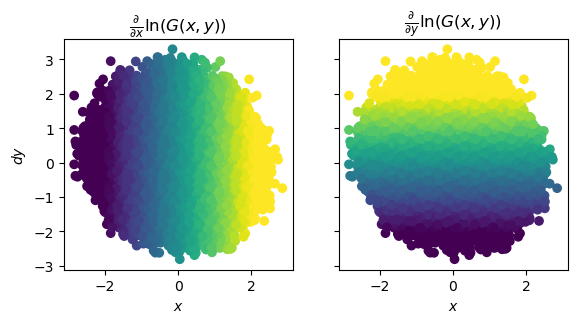

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3), sharex=True, sharey=True)
ax[0].scatter(x, y, c=dfdx, vmin=-2, vmax=2)
ax[1].scatter(x, y, c=dfdy, vmin=-2, vmax=2)
ax[0].set(title='$\\frac{\\partial}{\\partial x} \\ln(G(x, y))$', xlabel='$x$', ylabel='$dy$')
ax[1].set(title='$\\frac{\\partial}{\\partial y} \\ln(G(x, y))$', xlabel='$x$')

This looks exactly like what we'd expect. Let's try fitting these along side out Gaussian components. Here we will be assuming that the gradients of our first guess at the Gaussian are pretty close to the truth.

In [13]:
X = np.vstack([x**0, x**2, y**2, x * y, dfdx, dfdy]).T

In [14]:
k = np.hypot(y, x) < 1
sigma_w_inv = X[k].T.dot(X[k]/fe[k, None]**2)
B = X[k].T.dot(f[k]/fe[k]**2)
w = np.linalg.solve(sigma_w_inv, B)
werr = np.linalg.inv(sigma_w_inv).diagonal()**0.5

A = w[0]
rho = w[3]**2/(w[1]*w[2])
sigma_x = np.sqrt(-(1/(2*w[1] * (1-rho**2))))
sigma_y = np.sqrt(-(1/(2*w[2] * (1-rho**2))))
s_x, s_y = w[4:6]

In [15]:
print('Shift in x:', s_x, '$\pm$', werr[4])
print('Shift in y:', s_y, '$\pm$', werr[5])

Shift in x: 0.0028486167558469605 $\pm$ 0.0006868306085947307
Shift in y: -0.021359380259121166 $\pm$ 0.0006744008637879696


Our shifts are small, but significant. We can now update $x$ and $y$ to account for these shifts

In [16]:
# updated gradients
dfx = (1/1-rho**2) * ((x/sigma_x**2) - rho * (y/(sigma_x * sigma_y)))
dfy = (1/1-rho**2) * ((y/sigma_y**2) - rho * (x/(sigma_x * sigma_y)))
# updated positions
X = np.vstack([x**0, (x - s_x)**2, (y - s_y)**2, (x - s_x) * (y - s_y), dfdx, dfdy]).T

k = np.hypot(y, x) < 1
sigma_w_inv = X[k].T.dot(X[k]/fe[k, None]**2)
B = X[k].T.dot(f[k]/fe[k]**2)
w = np.linalg.solve(sigma_w_inv, B)
werr = np.linalg.inv(sigma_w_inv).diagonal()**0.5

A = w[0]
rho = w[3]**2/(w[1]*w[2])
sigma_x = np.sqrt(-(1/(2*w[1] * (1-rho**2))))
sigma_y = np.sqrt(-(1/(2*w[2] * (1-rho**2))))
s_x2, s_y2 = w[4:6]

A_err = werr[0]
w3_err = np.abs((w[3]**2) * 2 * werr[3]/w[3])
rho_err = np.abs(rho) * np.sqrt((w3_err/w[3])**2 + (werr[1]/w[1])**2 + (werr[2]/w[2])**2)
sigma_x_2_err = np.sqrt(((np.abs((rho) * 2 * rho_err/rho))**2 + (werr[1]/w[1])**2))
sigma_x_err = np.abs(sigma_x * -0.5 * (sigma_x_2_err/sigma_x**2))

# updated gradients
dfx = (1/1-rho**2) * ((x/sigma_x**2) - rho * (y/(sigma_x * sigma_y)))
dfy = (1/1-rho**2) * ((y/sigma_y**2) - rho * (x/(sigma_x * sigma_y)))


sigma_y_2_err = np.sqrt(((np.abs((rho) * 2 * rho_err/rho))**2 + (werr[2]/w[2])**2))
sigma_y_err = np.abs(sigma_y * -0.5 * (sigma_y_2_err/sigma_y**2))
s_x_err2 = werr[4]
s_y_err2 = werr[5]
print('Shift in x:', s_x2, '$\pm$', s_x_err2)
print('Shift in y:', s_y2, '$\pm$', s_y_err2)

Shift in x: -3.0201170987073778e-05 $\pm$ 0.0006871356482153305
Shift in y: 6.335136020687893e-05 $\pm$ 0.000675203613708894


Now the shifts we find are insignificant.

[Text(0, 0.5, '$log$ Normalized Flux'), Text(0.5, 0, '$\\sqrt{x^2 + y^2}$')]

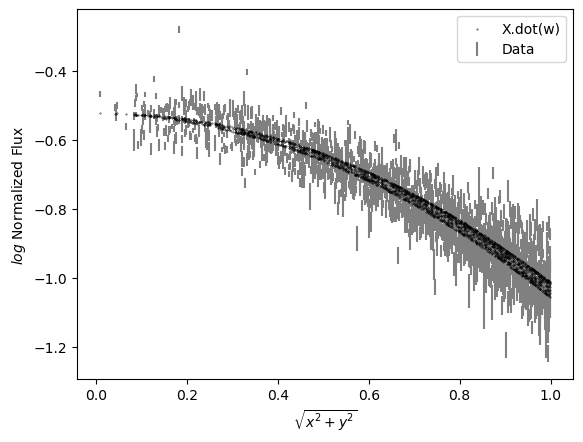

In [17]:
fig, ax = plt.subplots()
ax.errorbar(np.hypot(x, y)[k], f[k], fe[k], color='grey', ls='', label='Data')
ax.scatter(np.hypot(x, y)[k], X.dot(w)[k], c='k', label='X.dot(w)', zorder=10, s=0.1)
plt.legend()
ax.set(ylabel="$log$ Normalized Flux", xlabel='$\sqrt{x^2 + y^2}$')

We can now

1. Fit a Gaussian to the centers of all the sources, finding $\sigma_x$, $\sigma_y$, and $\rho$
2. Find the (small) shift in the centers of the sources in position $s_x$ and $s_y$

The next step would be to fix $\sigma_x$, $\sigma_y$, $\rho$, $s_x$ and $s_y$ and find $\alpha$ which would be the best fit source flux. 

Unfortunately, this is likely not to be computable, because we have limited ourselves to the central region of the PRF. This means most of the sources will contribute only a single pixel to the dataset, and so we have too many free variables to fit the flux of every source. 

Now that we have a Gaussian for the central part of the PSF, and a shift in x and y, we need to expand our model to include the wings.

In [18]:
lnG_x_y = X.dot(w)

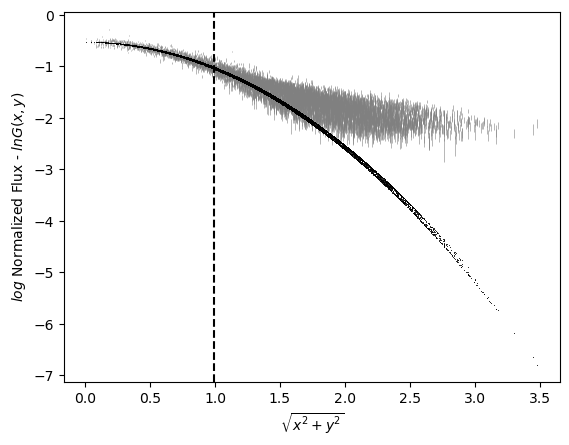

In [19]:
fig, ax = plt.subplots()
ax.errorbar(np.hypot(x, y), f, fe, color='grey', ls='', label='Data', lw=0.4)
ax.scatter(np.hypot(x, y), lnG_x_y, color='k', label='Model', lw=0.4, zorder=10, s=0.1)
ax.set(ylabel="$log$ Normalized Flux - $lnG(x, y)$", xlabel='$\sqrt{x^2 + y^2}$')
ax.axvline(np.mean([sigma_x, sigma_y]), c='k', ls='--')

We now need a functional form that can fit the wings. This doesn't need to be a Gaussian, but should be flexible enough to fit the core and the wings.

We'll use a spline in polar coordinates to do this.

In [20]:
from patsy import dmatrix
rad = np.hypot(x - s_x, y - s_y)
phi = np.arctan2(y - s_y, x - s_y)

# Spline in radial distance
r_knots = np.arange(0, rad.max(), np.mean([sigma_x, sigma_y]))
S_r = np.asarray(dmatrix("bs(x, knots=knots, degree=3, include_intercept=True)",
        {"x": list(np.hstack([rad, 0, rad.max()])), "knots": r_knots}))[:-2]

# Azimuthal dependence
S_phi = np.vstack([phi**0, np.sin(phi), np.cos(phi), np.sin(2*phi), np.cos(2*phi)]).T

# Combine them by taking the cross terms, but not the central region
S = np.hstack([S_r[:, :4], *[S_r[:, 4:] * p[:, None] for p in S_phi.T]])

/opt/conda/lib/python3.11/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


In [21]:
spline_r = S.dot(np.linalg.solve(S.T.dot(S/fe[:, None]**2) + np.diag(1/(np.ones(S.shape[1])*1e3)**2), S.T.dot(f/fe**2)))

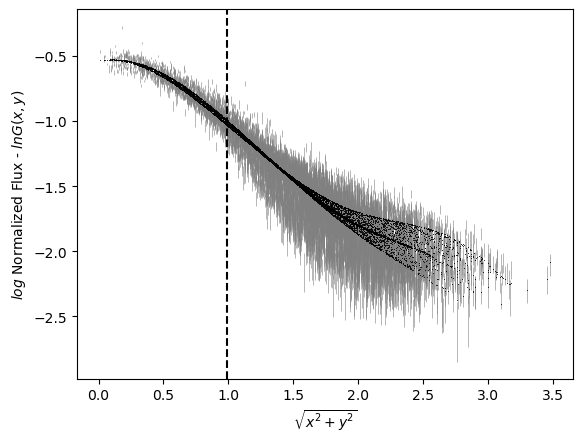

In [22]:
fig, ax = plt.subplots()
ax.errorbar(np.hypot(x, y), f, fe, color='grey', ls='', label='Data', lw=0.4)
ax.scatter(np.hypot(x, y), spline_r, color='k', label='Model', lw=0.4, zorder=10, s=0.1)
ax.set(ylabel="$log$ Normalized Flux - $lnG(x, y)$", xlabel='$\sqrt{x^2 + y^2}$')
ax.axvline(np.mean([sigma_x, sigma_y]), c='k', ls='--')

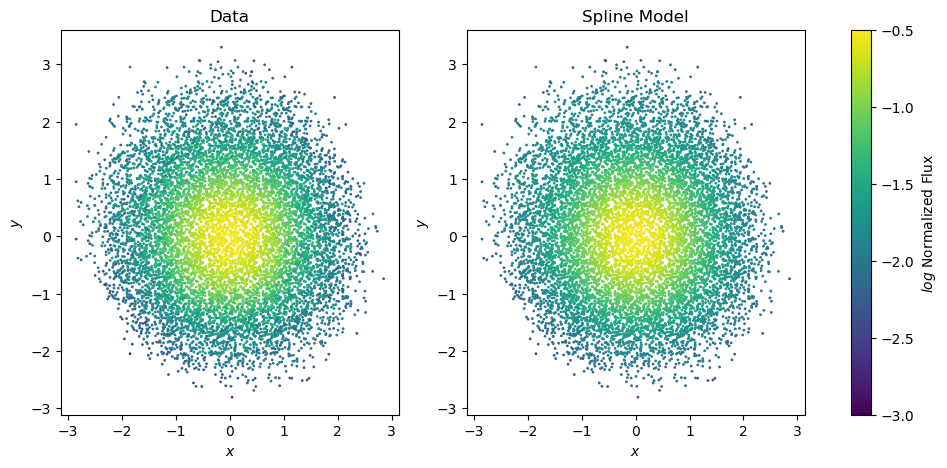

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im = ax[0].scatter(x, y, c=f, s=1, vmin=-3, vmax=-0.5)
cbar = plt.colorbar(im, ax=ax)
ax[0].set(xlabel='$x$', ylabel='$y$', title='Data')
im = ax[1].scatter(x, y, c=spline_r, s=1, vmin=-3, vmax=-0.5)
ax[1].set(xlabel='$x$', ylabel='$y$', title='Spline Model')
cbar.set_label("$log$ Normalized Flux")